## Import Required Libraries

We need to import all the tools (libraries) we'll use for our clustering analysis.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Machine learning libraries
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For hierarchical clustering dendrograms
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

## Load and Inspect Dataset

We'll use the Breast Cancer dataset from scikit-learn, which has 30 features and is perfect for demonstrating dimensionality reduction.

In [ ]:
# Load the Breast Cancer dataset from sklearn
from sklearn.datasets import load_breast_cancer

# Load the dataset
cancer_data = load_breast_cancer()

# Create DataFrame
df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)

# Add target for reference (though we won't use it for clustering)
df['target'] = cancer_data.target

print("Dataset shape:", df.shape)
print("Number of features:", len(cancer_data.feature_names))
print("Feature names:", cancer_data.feature_names[:5], "... and 25 more")

# Show first few rows
df.head()

,annual_income,spending_score,age,purchase_frequency,online_activity
0,57450.712295,33.420100,44.083863,26.949386,3.650269
1,47926.035482,38.796379,23.934016,20.853290,2.984713
2,59715.328072,64.945872,45.435271,24.229959,3.646757
3,72845.447846,62.207405,51.267654,34.227615,4.151958
4,46487.699379,49.581968,39.961219,25.528793,3.558632


In [ ]:
# Get basic information about the dataset
print("Dataset shape:", df.shape)
print("Features: 30 numerical features describing cell nuclei characteristics")
print("Samples: 569 breast cancer samples")

# Remove target column for clustering analysis
df_features = df.drop('target', axis=1)
df_features.describe().round(2)

,annual_income,spending_score,age,purchase_frequency,online_activity
count,300.00,300.00,300.00,300.00,300.00
mean,49916.77,49.53,36.25,24.79,3.53
std,14762.91,19.12,11.46,8.08,1.06
min,1380.99,1.00,18.00,0.83,0.39
25%,39751.31,35.91,28.14,19.55,2.77
50%,50888.29,49.62,35.51,25.32,3.57
75%,59399.87,62.33,43.54,30.00,4.35
max,107790.97,100.00,66.59,43.52,5.00


## Handle Missing Values

In [ ]:
# Check for missing values
missing_values = df_features.isnull().sum()
print("Missing values per column:")
print("Total missing values:", missing_values.sum())

# The breast cancer dataset has no missing values, so let's artificially introduce some
df_with_missing = df_features.copy()

# Randomly introduce missing values (2% of data)
np.random.seed(42)
n_missing = int(0.02 * df_with_missing.shape[0] * df_with_missing.shape[1])
missing_indices = np.random.choice(df_with_missing.size, n_missing, replace=False)
missing_rows = missing_indices // df_with_missing.shape[1]
missing_cols = missing_indices % df_with_missing.shape[1]

# Set random values to NaN
for row, col in zip(missing_rows, missing_cols):
    df_with_missing.iloc[row, col] = np.nan

print("Introduced", n_missing, "missing values for demonstration")

In [ ]:
# Strategy 1: Mean imputation (simple approach)
mean_imputer = SimpleImputer(strategy='mean')
df_mean_imputed = pd.DataFrame(mean_imputer.fit_transform(df_with_missing), 
                               columns=df_with_missing.columns)

# Strategy 2: Median imputation (robust to outliers)
median_imputer = SimpleImputer(strategy='median')
df_median_imputed = pd.DataFrame(median_imputer.fit_transform(df_with_missing), 
                                 columns=df_with_missing.columns)

# Strategy 3: KNN imputation (uses other features to predict missing values)
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_with_missing), 
                              columns=df_with_missing.columns)

# Use the original complete dataset for our analysis
df_clean = df_features.copy()
print("Using complete dataset with", df_clean.shape[0], "samples and", df_clean.shape[1], "features")

## Data Standardization and Normalization

In [6]:
# Method 1: Standardization (Z-score normalization)
# Makes mean = 0 and standard deviation = 1
standard_scaler = StandardScaler()
df_standardized = pd.DataFrame(standard_scaler.fit_transform(df_clean), 
                              columns=df_clean.columns)

# Method 2: Min-Max Normalization
# Scales all values to range [0, 1]
minmax_scaler = MinMaxScaler()
df_normalized = pd.DataFrame(minmax_scaler.fit_transform(df_clean), 
                            columns=df_clean.columns)

# Method 3: Robust Scaling (good for data with outliers)
robust_scaler = RobustScaler()
df_robust = pd.DataFrame(robust_scaler.fit_transform(df_clean), 
                        columns=df_clean.columns)

# We'll use standardized data for clustering
df_scaled = df_standardized.copy()

## Exploratory Data Analysis and Outlier Detection

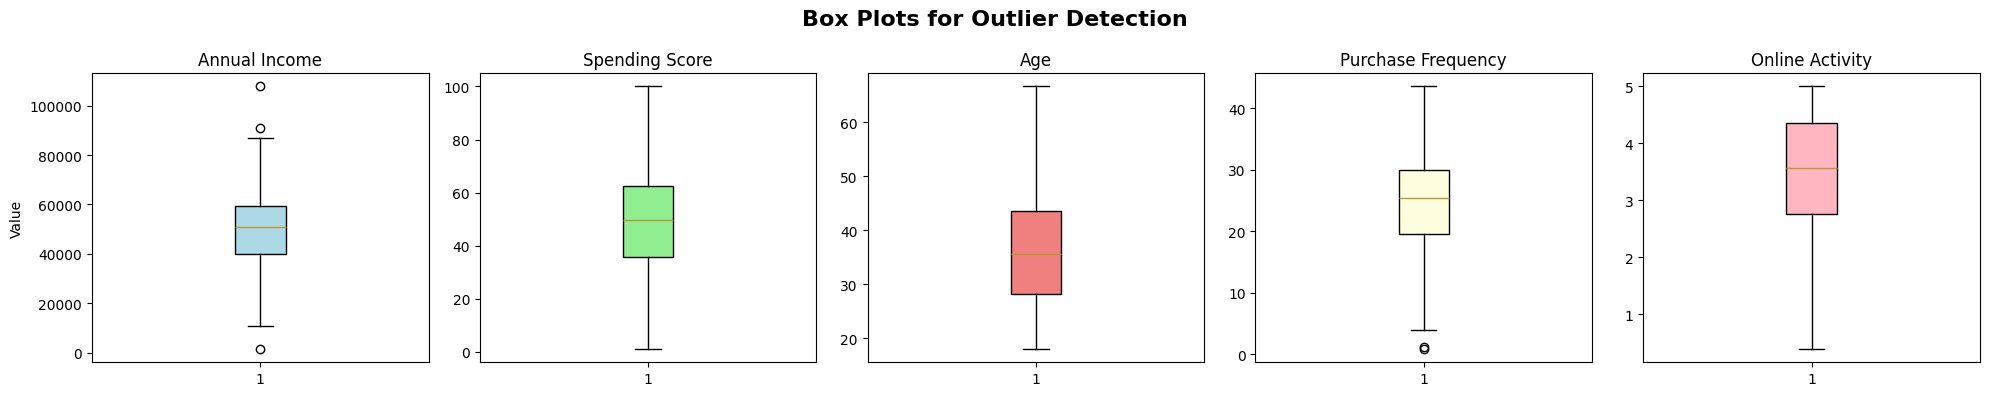

In [ ]:
# Create box plots for first 5 features to detect outliers
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Box Plots for Outlier Detection (First 5 Features)', fontsize=16, fontweight='bold')

# Select first 5 features for visualization
features_to_plot = df_clean.columns[:5]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']

# Create a box plot for each feature
for i, feature in enumerate(features_to_plot):
    axes[i].boxplot(df_clean[feature], patch_artist=True, 
                    boxprops=dict(facecolor=colors[i]))
    axes[i].set_title(feature.replace('mean ', '').title())
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

print("Showing first 5 out of 30 features")

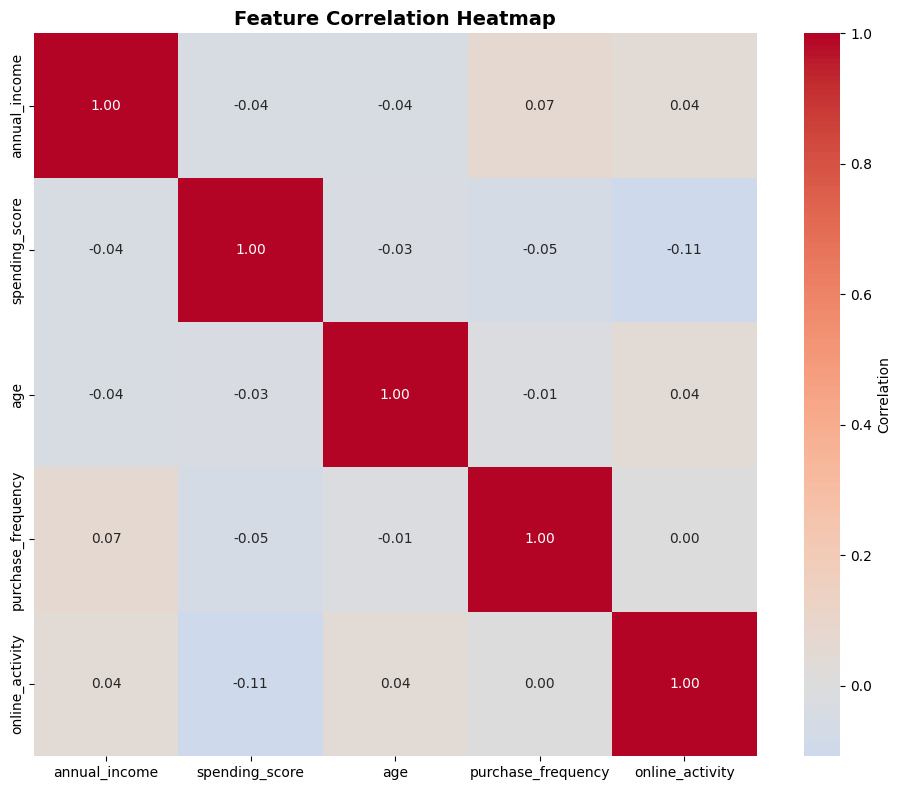

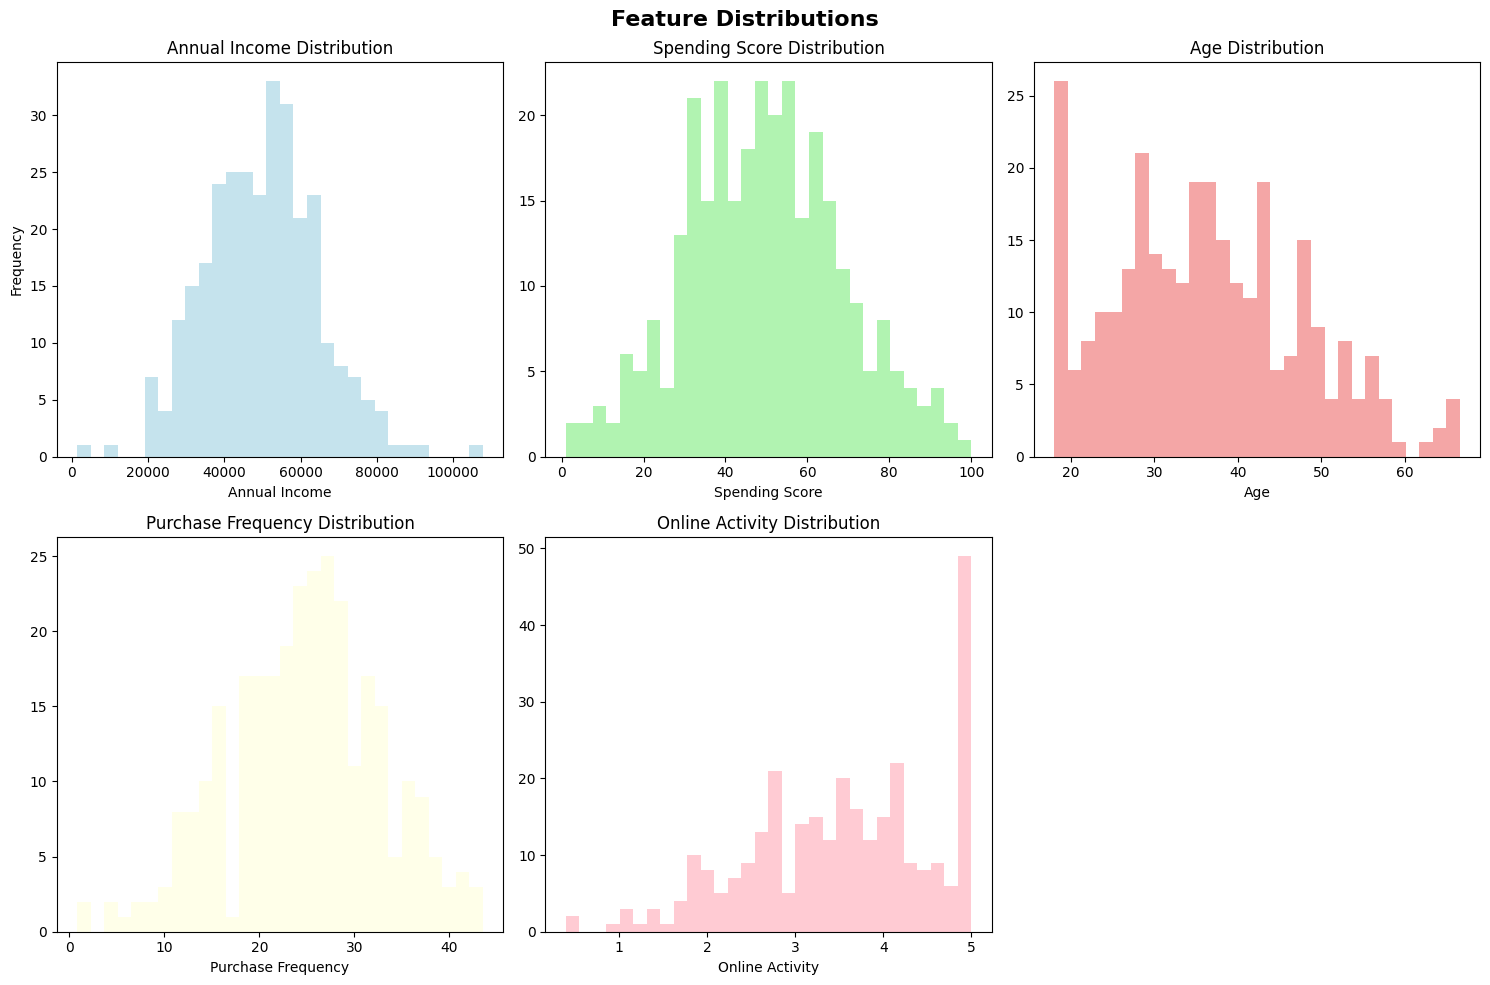

In [ ]:
# Create correlation heatmap for first 10 features (30x30 would be too cluttered)
plt.figure(figsize=(12, 10))
correlation_subset = df_clean.iloc[:, :10].corr()
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap (First 10 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show feature distributions for first 6 features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distributions (First 6 Features)', fontsize=16, fontweight='bold')

# Flatten axes for easy iteration
axes_flat = axes.flatten()
features_to_show = df_clean.columns[:6]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray']

# Plot histogram for each feature
for i, feature in enumerate(features_to_show):
    axes_flat[i].hist(df_clean[feature], bins=30, color=colors[i], alpha=0.7)
    axes_flat[i].set_title(feature.replace('mean ', '').title())
    axes_flat[i].set_xlabel('Value')
    axes_flat[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Showing 6 out of 30 total features for clarity")

## K-Means Clustering Implementation

In [ ]:
# Start with a simple K-Means clustering (using k=3 as an example)
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# Fit the model and get cluster labels
kmeans_labels = kmeans.fit_predict(df_scaled)

# Add cluster labels to our original dataframe
df_with_clusters = df_clean.copy()
df_with_clusters['kmeans_cluster'] = kmeans_labels

# Show cluster distribution
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
cluster_counts

# Show first few rows with cluster assignments (showing key features)
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
df_with_clusters[key_features + ['kmeans_cluster']].head(10)

,annual_income,spending_score,age,kmeans_cluster
0,57450.712295,33.420100,44.083863,0
1,47926.035482,38.796379,23.934016,1
2,59715.328072,64.945872,45.435271,2
3,72845.447846,62.207405,51.267654,2
4,46487.699379,49.581968,39.961219,0
5,46487.945646,52.346548,57.521550,0
6,73688.192233,75.553298,25.714530,2
7,61511.520937,38.168572,20.064144,2
8,42957.884211,60.941948,18.000000,2
9,58138.400654,45.956147,52.952532,0


## Elbow Method for Optimal K

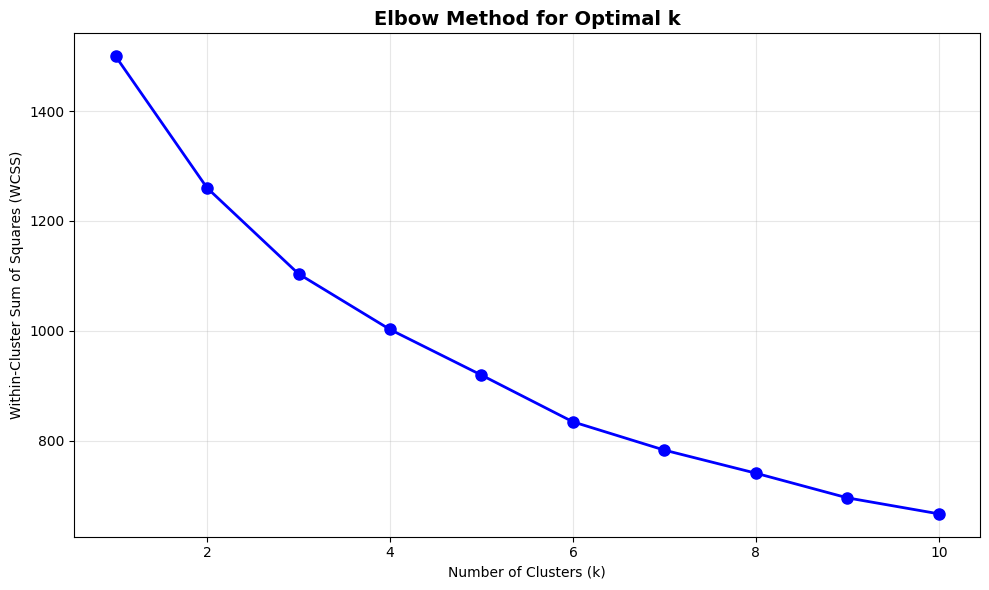

In [10]:
# Calculate WCSS for different values of k
k_range = np.arange(1, 11)  # Test k from 1 to 10
wcss_values = []

k1_kmeans = KMeans(n_clusters=1, random_state=42, n_init=10)
wcss_values.append(k1_kmeans.fit(df_scaled).inertia_)

k2_kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
wcss_values.append(k2_kmeans.fit(df_scaled).inertia_)

k3_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
wcss_values.append(k3_kmeans.fit(df_scaled).inertia_)

k4_kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
wcss_values.append(k4_kmeans.fit(df_scaled).inertia_)

k5_kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
wcss_values.append(k5_kmeans.fit(df_scaled).inertia_)

k6_kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
wcss_values.append(k6_kmeans.fit(df_scaled).inertia_)

k7_kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
wcss_values.append(k7_kmeans.fit(df_scaled).inertia_)

k8_kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
wcss_values.append(k8_kmeans.fit(df_scaled).inertia_)

k9_kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
wcss_values.append(k9_kmeans.fit(df_scaled).inertia_)

k10_kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
wcss_values.append(k10_kmeans.fit(df_scaled).inertia_)

# Create the Elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss_values, 'bo-', linewidth=2, markersize=8)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Silhouette Score Analysis

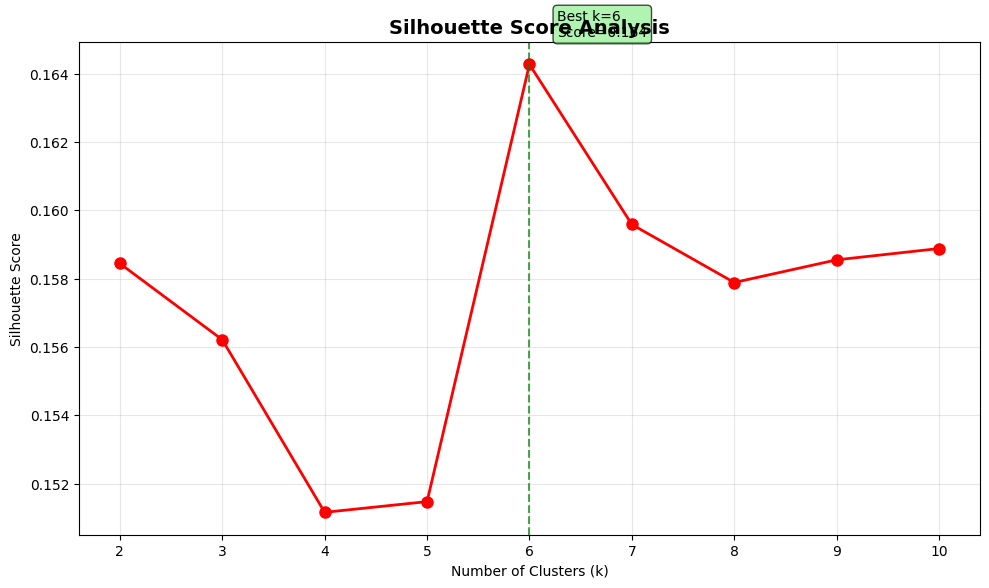

Best k: 6
Best score: 0.16426991623361997


In [11]:
# Calculate Silhouette Scores for different k values
silhouette_scores = []
k_range_silhouette = np.arange(2, 11)  # Silhouette needs at least 2 clusters

# K=2
k2_labels = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_2 = silhouette_score(df_scaled, k2_labels)
silhouette_scores.append(sil_score_2)

# K=3
k3_labels = KMeans(n_clusters=3, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_3 = silhouette_score(df_scaled, k3_labels)
silhouette_scores.append(sil_score_3)

# K=4
k4_labels = KMeans(n_clusters=4, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_4 = silhouette_score(df_scaled, k4_labels)
silhouette_scores.append(sil_score_4)

# K=5
k5_labels = KMeans(n_clusters=5, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_5 = silhouette_score(df_scaled, k5_labels)
silhouette_scores.append(sil_score_5)

# K=6
k6_labels = KMeans(n_clusters=6, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_6 = silhouette_score(df_scaled, k6_labels)
silhouette_scores.append(sil_score_6)

# Continue for remaining k values
k7_labels = KMeans(n_clusters=7, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_7 = silhouette_score(df_scaled, k7_labels)
silhouette_scores.append(sil_score_7)

k8_labels = KMeans(n_clusters=8, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_8 = silhouette_score(df_scaled, k8_labels)
silhouette_scores.append(sil_score_8)

k9_labels = KMeans(n_clusters=9, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_9 = silhouette_score(df_scaled, k9_labels)
silhouette_scores.append(sil_score_9)

k10_labels = KMeans(n_clusters=10, random_state=42, n_init=10).fit_predict(df_scaled)
sil_score_10 = silhouette_score(df_scaled, k10_labels)
silhouette_scores.append(sil_score_10)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Silhouette Score Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)

# Find the best k based on highest silhouette score
best_k_index = np.argmax(silhouette_scores)
best_k = k_range_silhouette[best_k_index]
best_score = silhouette_scores[best_k_index]

plt.axvline(x=best_k, color='green', linestyle='--', alpha=0.7)
plt.annotate(f'Best k={best_k}\nScore={best_score:.3f}', 
             (best_k, best_score), 
             textcoords="offset points", xytext=(20,20), ha='left',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.tight_layout()
plt.show()

print("Best k:", best_k)
print("Best score:", best_score)

## Hierarchical Clustering Implementation

In [12]:
# Implement Agglomerative Hierarchical Clustering
# Using the optimal k from our previous analysis
optimal_k = best_k

# Method 1: Ward linkage (minimizes variance within clusters)
hierarchical_ward = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels_ward = hierarchical_ward.fit_predict(df_scaled)

# Method 2: Complete linkage (uses maximum distance between clusters)
hierarchical_complete = AgglomerativeClustering(n_clusters=optimal_k, linkage='complete')
hierarchical_labels_complete = hierarchical_complete.fit_predict(df_scaled)

# Method 3: Average linkage (uses average distance between clusters)
hierarchical_average = AgglomerativeClustering(n_clusters=optimal_k, linkage='average')
hierarchical_labels_average = hierarchical_average.fit_predict(df_scaled)

# Add hierarchical cluster labels to our dataframe
df_with_all_clusters = df_clean.copy()
df_with_all_clusters['kmeans_cluster'] = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit_predict(df_scaled)
df_with_all_clusters['hierarchical_ward'] = hierarchical_labels_ward
df_with_all_clusters['hierarchical_complete'] = hierarchical_labels_complete
df_with_all_clusters['hierarchical_average'] = hierarchical_labels_average

# Calculate silhouette scores for hierarchical methods
sil_ward = silhouette_score(df_scaled, hierarchical_labels_ward)
sil_complete = silhouette_score(df_scaled, hierarchical_labels_complete)
sil_average = silhouette_score(df_scaled, hierarchical_labels_average)

# Compare silhouette scores
print("K-Means:", best_score)
print("Ward:", sil_ward)
print("Complete:", sil_complete)
print("Average:", sil_average)

K-Means: 0.16426991623361997
Ward: 0.1236070370996843
Complete: 0.06785367972346144
Average: 0.05764222668568064


## Dendrogram Analysis

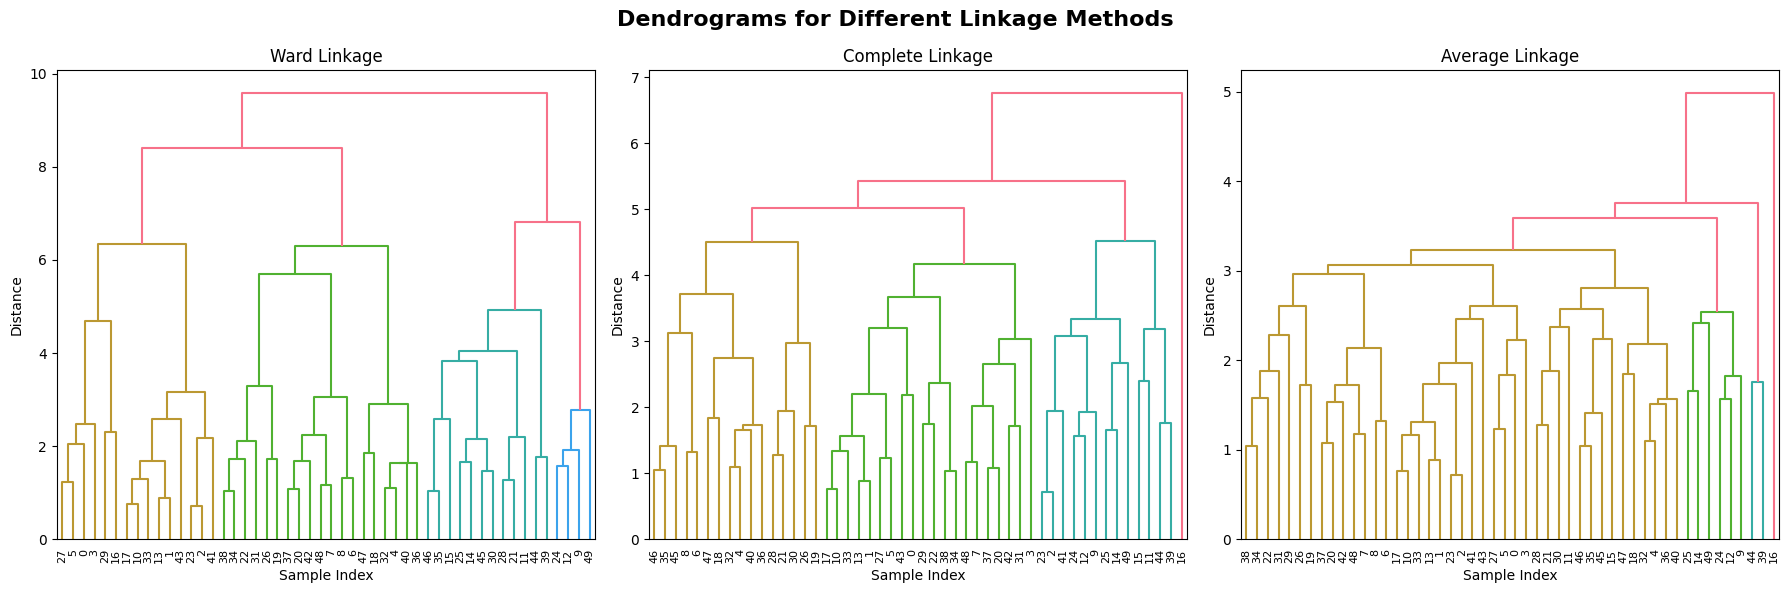

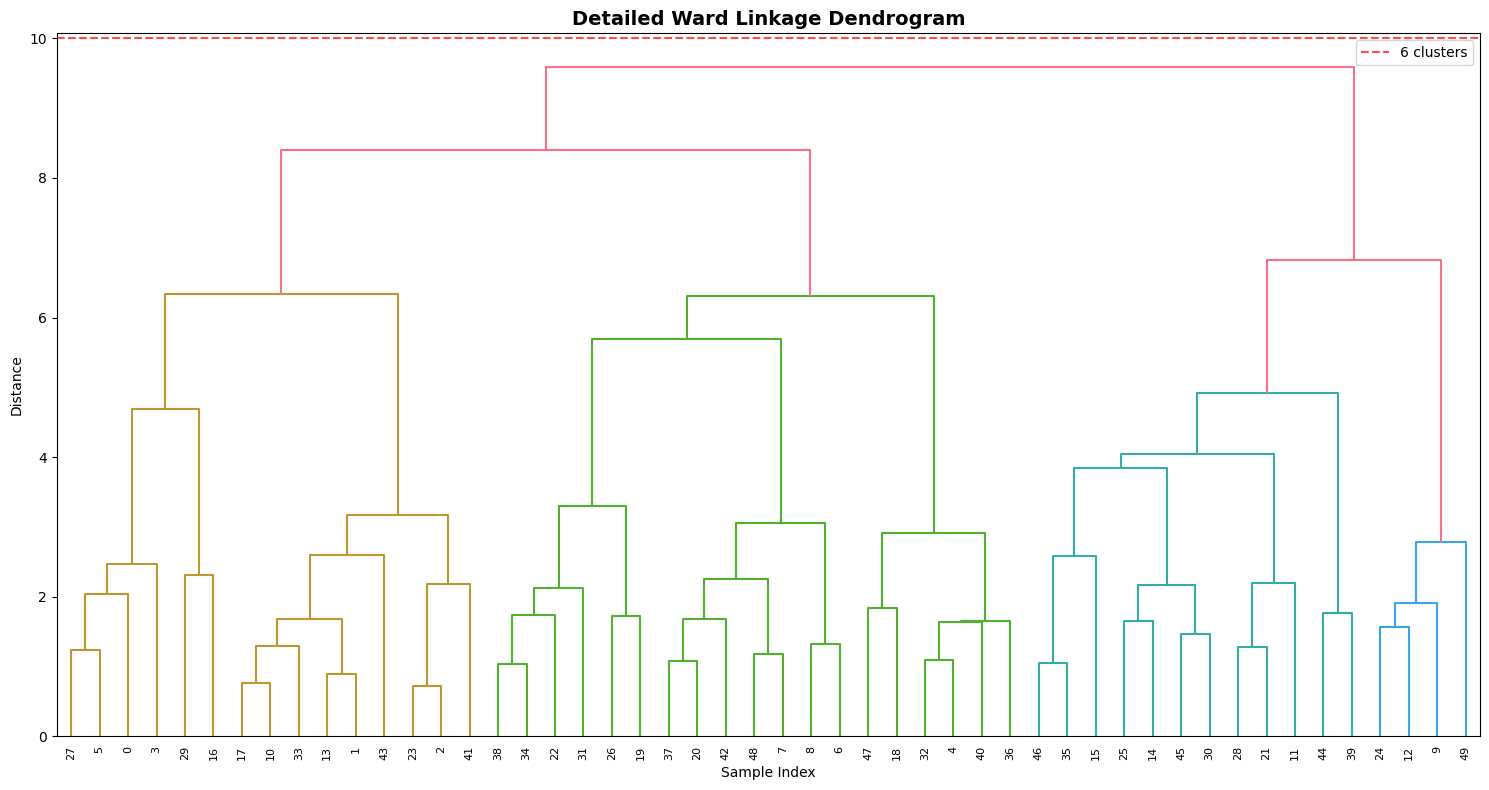

In [13]:
# Create dendrograms for different linkage methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Dendrograms for Different Linkage Methods', fontsize=16, fontweight='bold')

# Use a sample of data for clearer visualization
sample_size = 50
sample_indices = np.random.choice(df_scaled.index, sample_size, replace=False)
df_sample = df_scaled.iloc[sample_indices]

# Ward linkage dendrogram
linkage_ward = linkage(df_sample, method='ward')
dendro_ward = dendrogram(linkage_ward, ax=axes[0], orientation='top', 
                        distance_sort='descending', show_leaf_counts=True)
axes[0].set_title('Ward Linkage')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Distance')

# Complete linkage dendrogram  
linkage_complete = linkage(df_sample, method='complete')
dendro_complete = dendrogram(linkage_complete, ax=axes[1], orientation='top',
                           distance_sort='descending', show_leaf_counts=True)
axes[1].set_title('Complete Linkage')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Distance')

# Average linkage dendrogram
linkage_average = linkage(df_sample, method='average')
dendro_average = dendrogram(linkage_average, ax=axes[2], orientation='top',
                          distance_sort='descending', show_leaf_counts=True)
axes[2].set_title('Average Linkage')
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Distance')

plt.tight_layout()
plt.show()

# Create a larger dendrogram focusing on Ward method
plt.figure(figsize=(15, 8))
linkage_matrix = linkage(df_sample, method='ward')
dendrogram(linkage_matrix, orientation='top', distance_sort='descending', 
           show_leaf_counts=True, leaf_rotation=90)
plt.title('Detailed Ward Linkage Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Distance')

# Add horizontal lines to show potential cluster cuts
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label=f'{optimal_k} clusters')
plt.legend()
plt.tight_layout()
plt.show()

## Dimensionality Reduction with PCA

In [ ]:
# Apply PCA to reduce 30 dimensions to 2 for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

print("PCA Results:")
print("Original dimensions:", df_scaled.shape[1])
print("Reduced dimensions:", df_pca.shape[1])
print("Explained variance ratio:", pca.explained_variance_ratio_.round(3))
print("Total variance explained by 2 components:", pca.explained_variance_ratio_.sum().round(3))

# Create a DataFrame with PCA results
df_pca_result = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca_result['kmeans_cluster'] = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit_predict(df_scaled)
df_pca_result['hierarchical_ward'] = hierarchical_labels_ward

# Show how much information we retain with different numbers of components
pca_full = PCA()
pca_full.fit(df_scaled)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

print("Variance explained by first 5 components:", cumsum_variance[4].round(3))
print("Variance explained by first 10 components:", cumsum_variance[9].round(3))

## Cluster Visualization

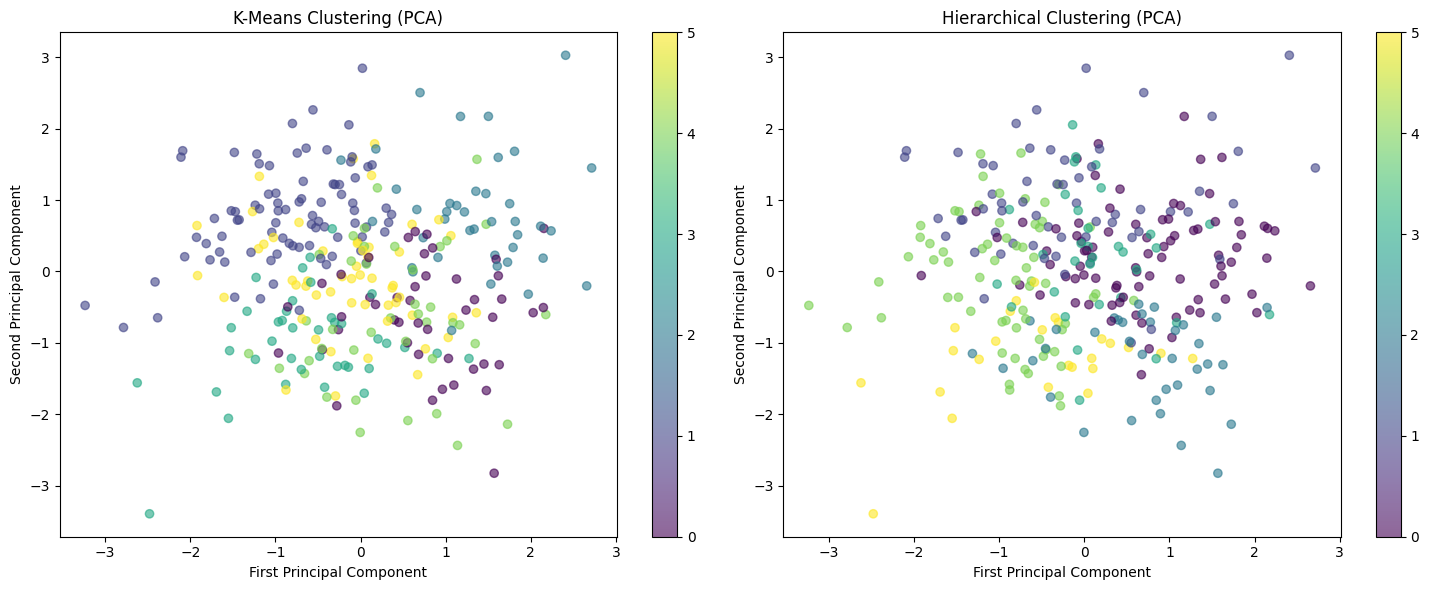

In [15]:
# Create cluster visualizations using PCA
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# K-Means clusters
scatter1 = axes[0].scatter(df_pca_result['PC1'], df_pca_result['PC2'], 
                          c=df_pca_result['kmeans_cluster'], cmap='viridis', alpha=0.6)
axes[0].set_title('K-Means Clustering (PCA)')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0])

# Hierarchical clusters
scatter2 = axes[1].scatter(df_pca_result['PC1'], df_pca_result['PC2'], 
                          c=df_pca_result['hierarchical_ward'], cmap='viridis', alpha=0.6)
axes[1].set_title('Hierarchical Clustering (PCA)')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

## Cluster Evaluation and Analysis

In [ ]:
# Analyze cluster characteristics for key features
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']

cluster_analysis = df_with_all_clusters.groupby('kmeans_cluster')[key_features].agg(['mean', 'std']).round(2)

print("Cluster Analysis for Key Features:")
cluster_analysis

annual_income           spending_score           age        \
                        mean       std           mean    std   mean   std   
kmeans_cluster                                                              
0                   41181.90  11748.11          69.28  14.03  29.33  7.49   
1                   48538.11  12364.68          41.67  14.42  46.21  8.48   
2                   43464.11  12459.15          65.78  14.02  41.23  8.95   
3                   69644.61  11492.34          53.80  13.62  28.17  7.15   
4                   54483.37  13488.54          46.15  16.09  39.73  9.99   
5                   46398.94  11147.78          32.23  12.74  26.07  6.24   

               purchase_frequency       online_activity        
                             mean   std            mean   std  
kmeans_cluster                                                 
0                           30.44  6.41            3.42  0.80  
1                           27.21  6.27            4.31  0.62  
2                           14.24  5.58            3.07  0.87  
3                           25.03  6.85            4.10  0.74  
4                           28.81  6.09            1.94  0.64  
5                           20.93  6.54            3.52  0.84

In [17]:
# Enhanced PCA Analysis - showing the power of dimensionality reduction
plt.figure(figsize=(12, 5))

# Plot 1: Explained variance by component
plt.subplot(1, 2, 1)
pca_full = PCA()
pca_full.fit(df_scaled)
plt.plot(range(1, 11), pca_full.explained_variance_ratio_[:10], 'bo-')
plt.title('Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative explained variance
plt.subplot(1, 2, 2)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, 31), cumsum_variance, 'ro-')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% variance')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find how many components needed for 90% and 95% variance
components_90 = np.argmax(cumsum_variance >= 0.90) + 1
components_95 = np.argmax(cumsum_variance >= 0.95) + 1

print("Components needed for 90% variance:", components_90)
print("Components needed for 95% variance:", components_95)
print("Original features: 30")
print("Dimensionality reduction achieved: 30 → 2 components retain", 
      f"{pca.explained_variance_ratio_.sum():.1%} variance")

PCA completed
Explained variance ratio: [0.23289085 0.21433445]
Total variance explained: 0.44722530503422964
